
--- Processing image pair: CT: medical\c01_1.tif, MRI: medical\c01_2.tif ---
Performing Original Laplacian Pyramid Fusion...


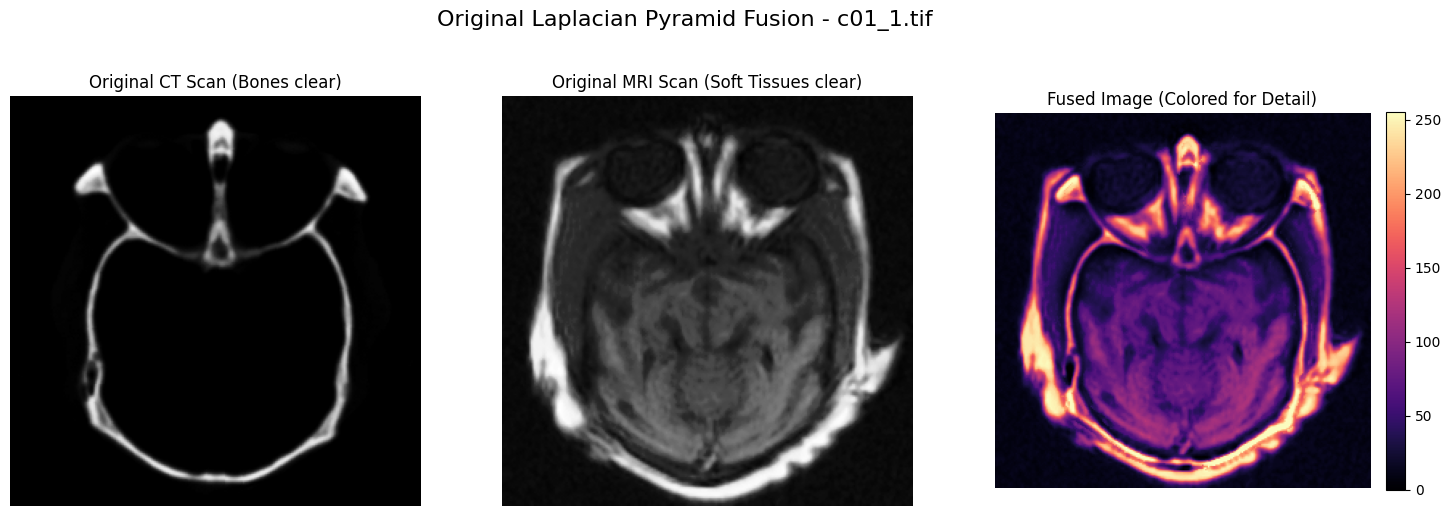

Performing Enhanced Laplacian Pyramid Fusion (emphasizing differences)...


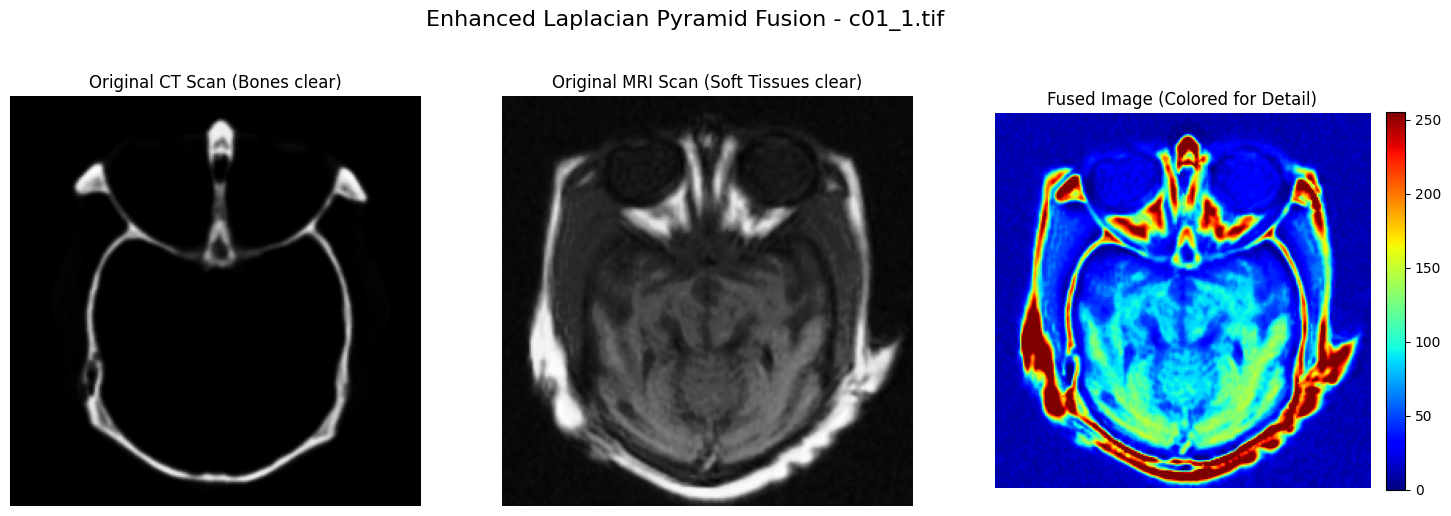


--- Processing image pair: CT: medical\c02_1.tif, MRI: medical\c02_2.tif ---
Performing Original Laplacian Pyramid Fusion...


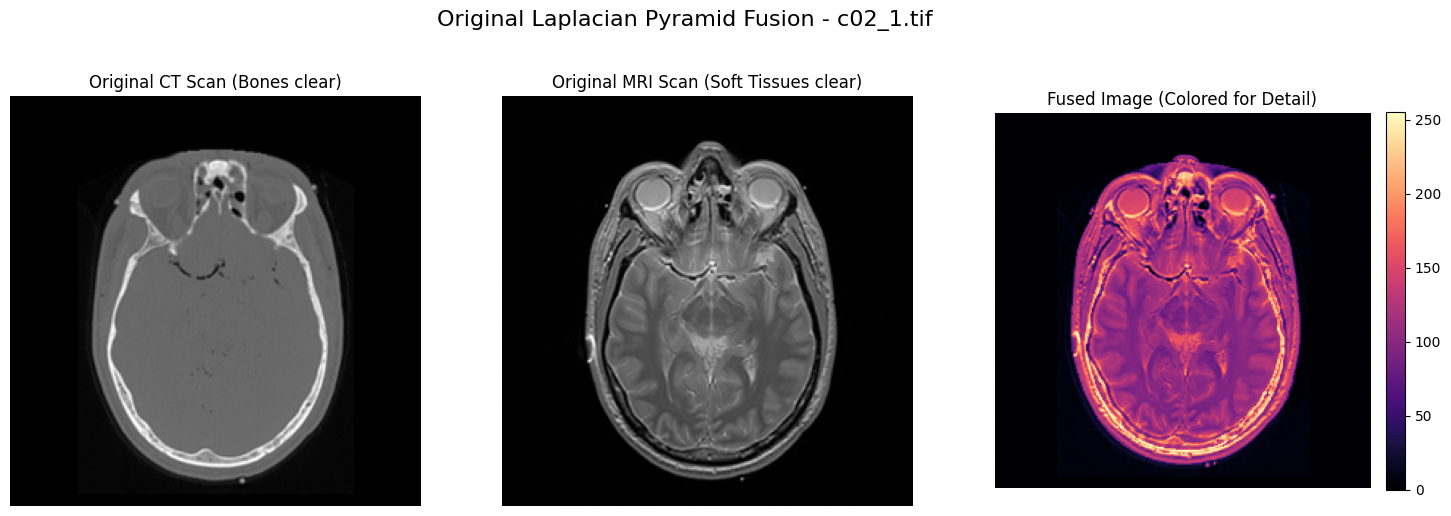

Performing Enhanced Laplacian Pyramid Fusion (emphasizing differences)...


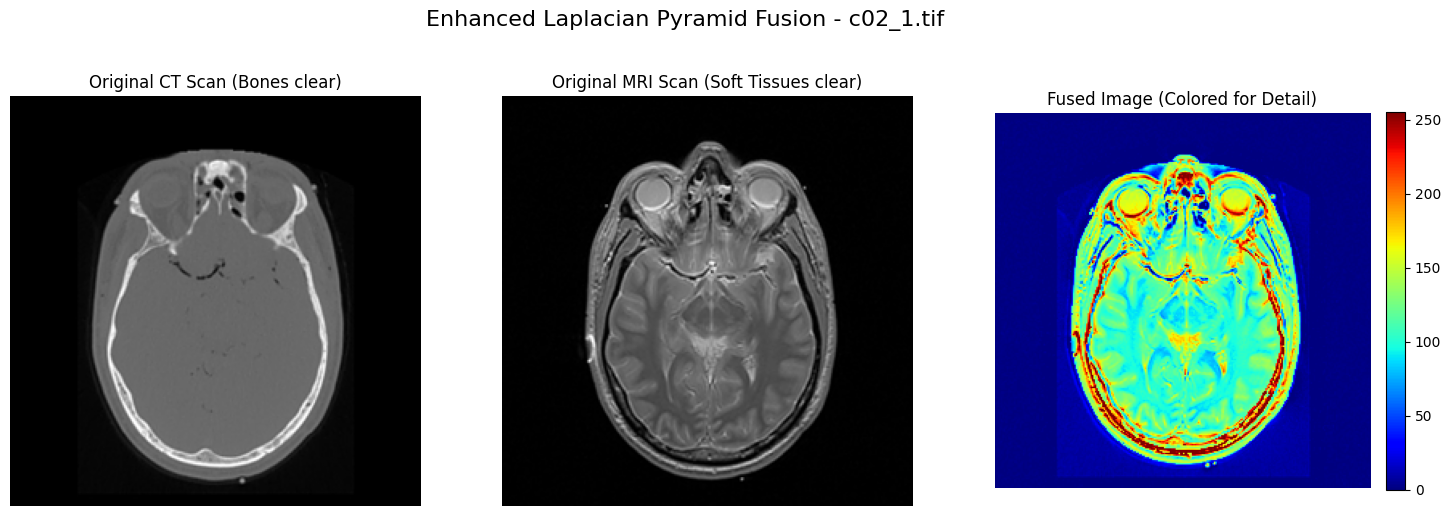


--- Processing image pair: CT: medical\c03_1.tif, MRI: medical\c03_2.tif ---
Performing Original Laplacian Pyramid Fusion...


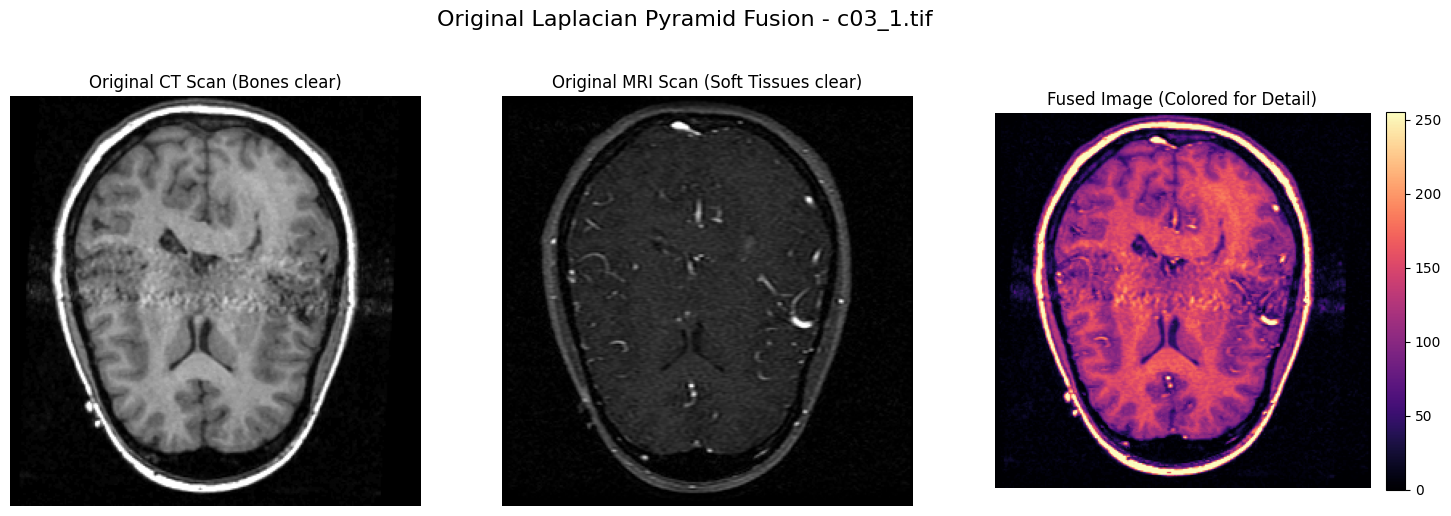

Performing Enhanced Laplacian Pyramid Fusion (emphasizing differences)...


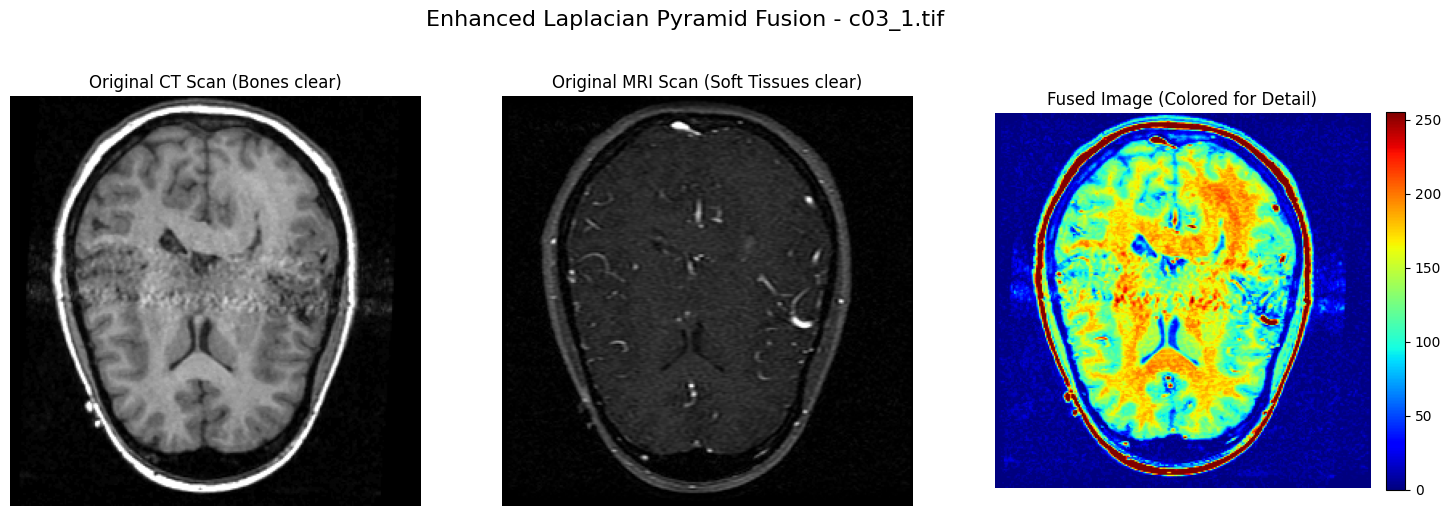


--- Processing image pair: CT: medical\c04_1.tif, MRI: medical\c04_2.tif ---
Performing Original Laplacian Pyramid Fusion...


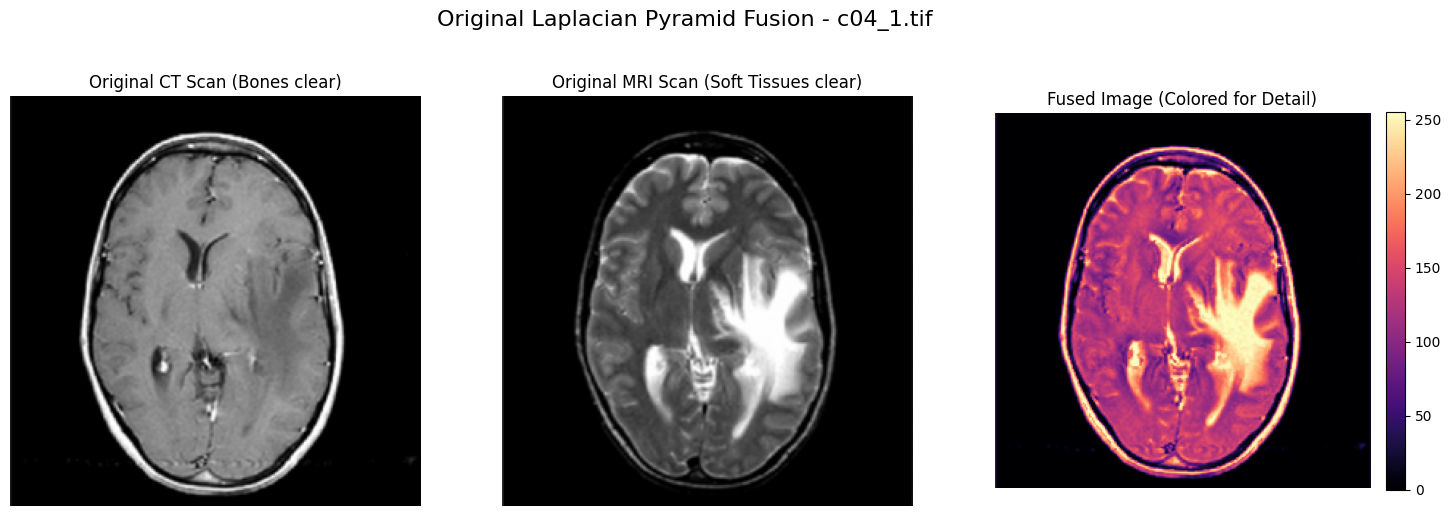

Performing Enhanced Laplacian Pyramid Fusion (emphasizing differences)...


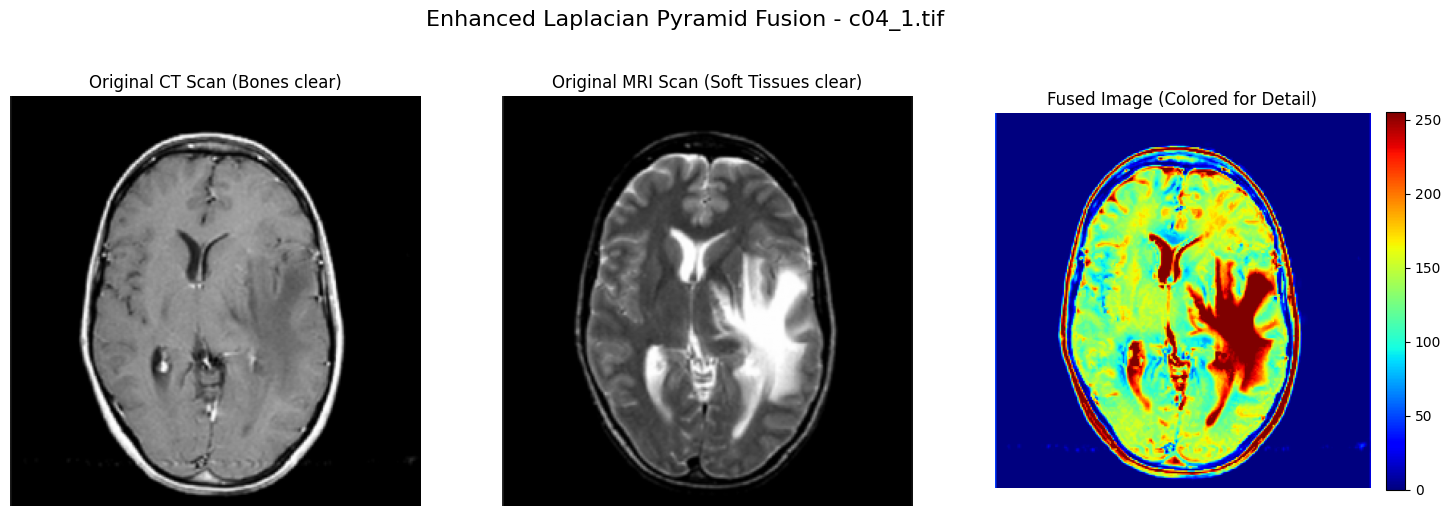


--- Processing image pair: CT: medical\c05_1.tif, MRI: medical\c05_2.tif ---
Performing Original Laplacian Pyramid Fusion...


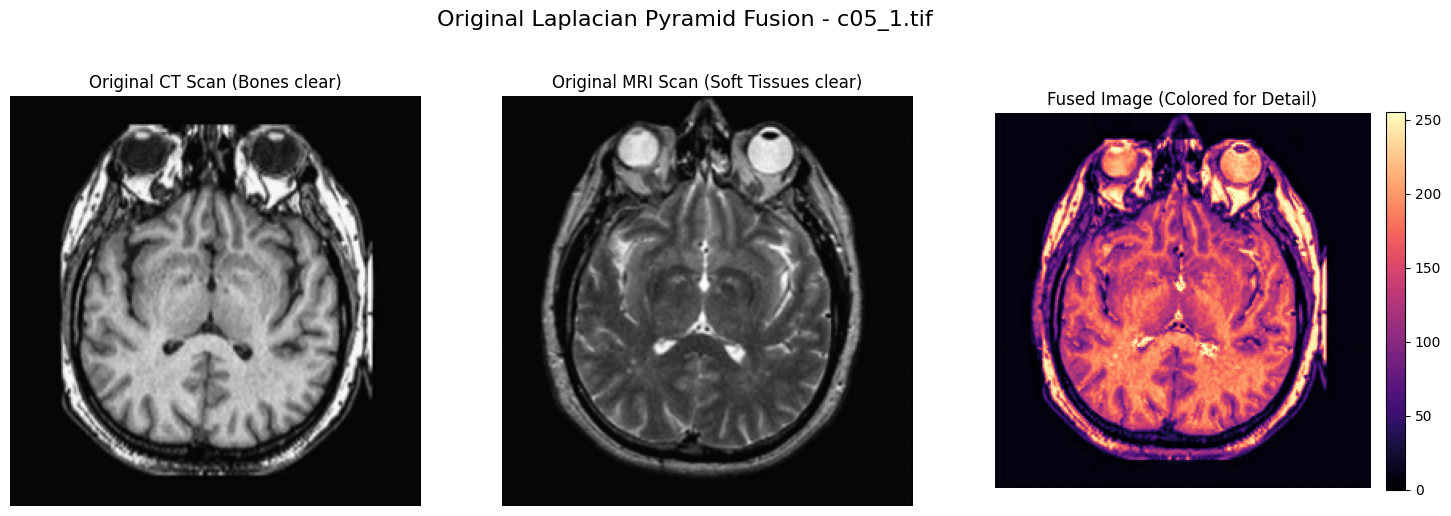

Performing Enhanced Laplacian Pyramid Fusion (emphasizing differences)...


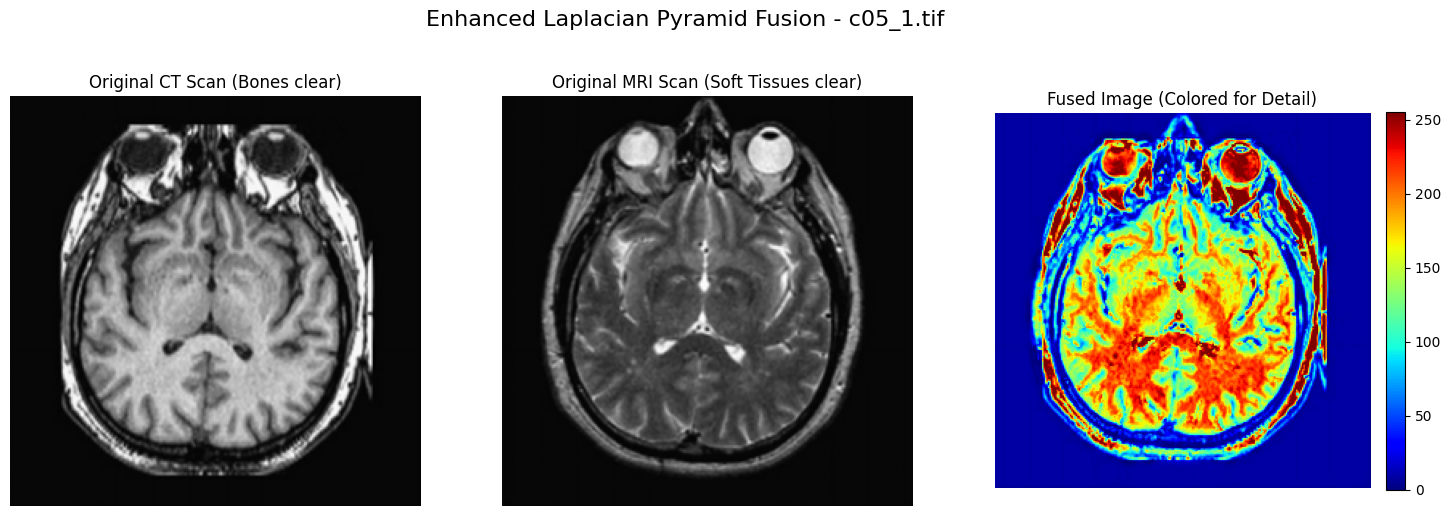


--- Processing image pair: CT: medical\c06_1.tif, MRI: medical\c06_2.tif ---
Performing Original Laplacian Pyramid Fusion...


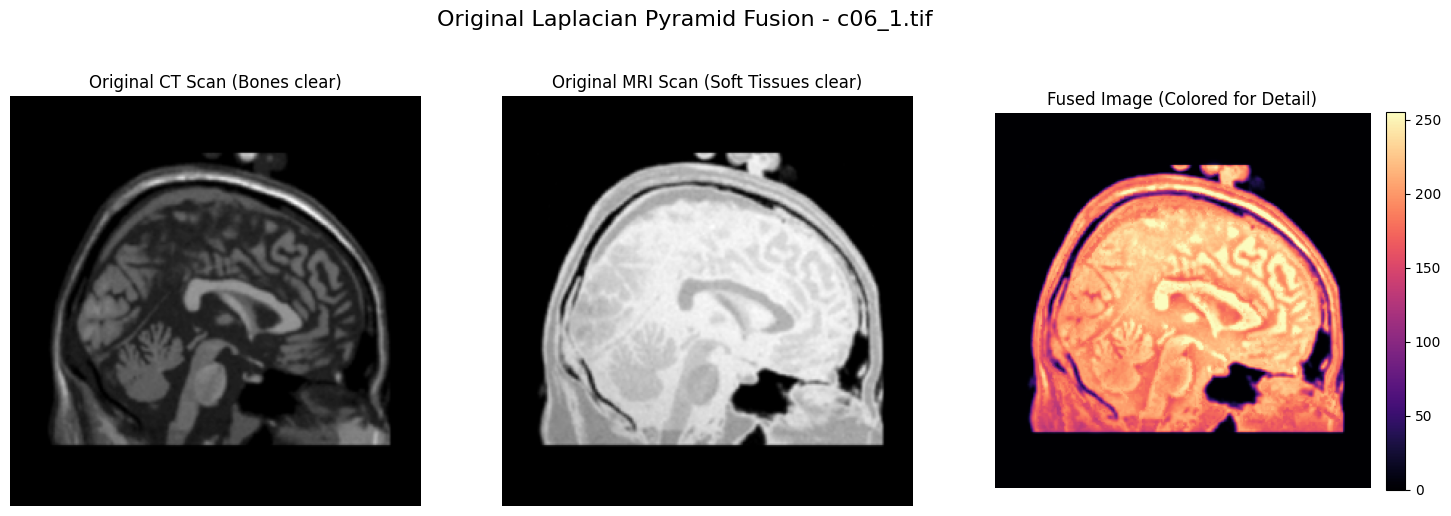

Performing Enhanced Laplacian Pyramid Fusion (emphasizing differences)...


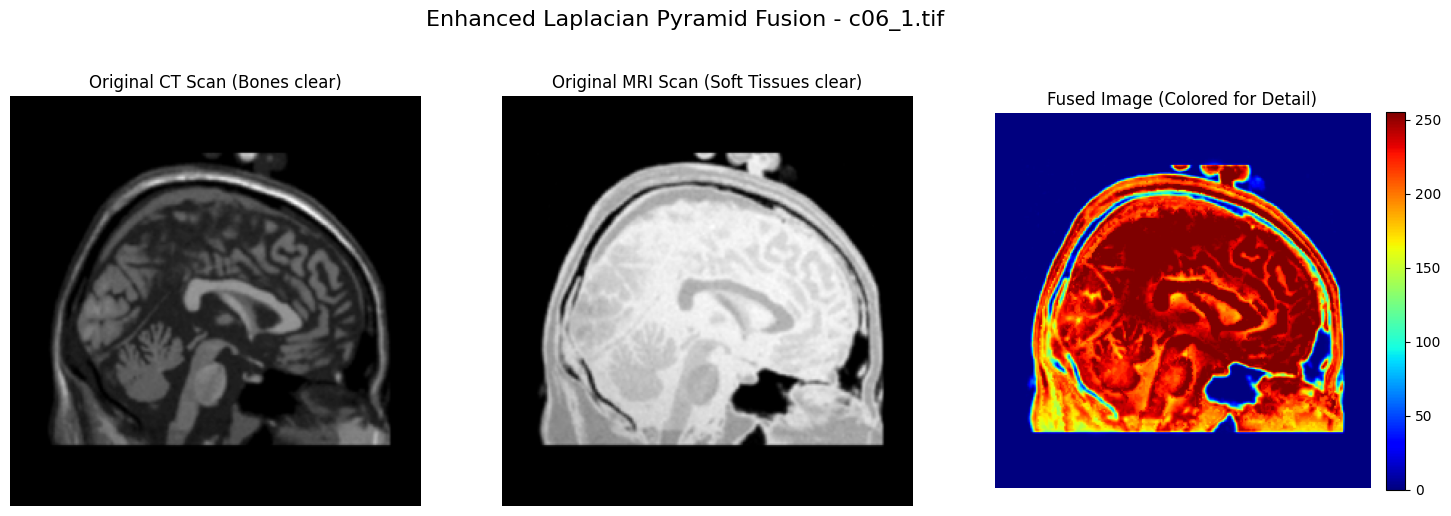


--- Processing image pair: CT: medical\c07_1.tif, MRI: medical\c07_2.tif ---
Performing Original Laplacian Pyramid Fusion...


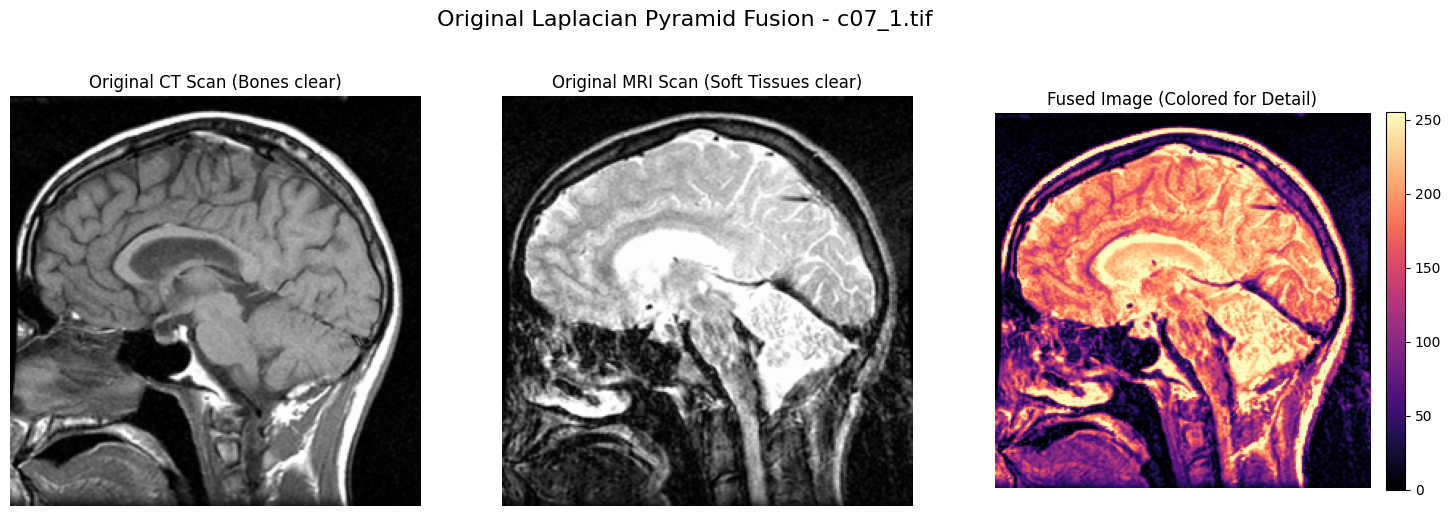

Performing Enhanced Laplacian Pyramid Fusion (emphasizing differences)...


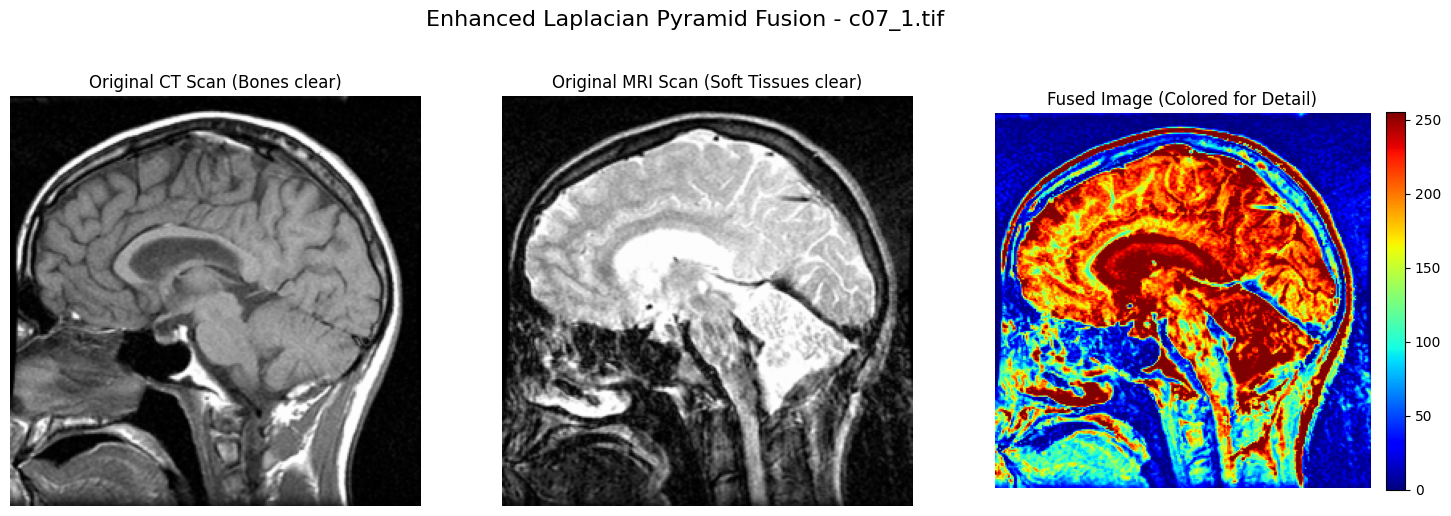


--- Processing image pair: CT: medical\c08_1.tif, MRI: medical\c08_2.tif ---
Performing Original Laplacian Pyramid Fusion...


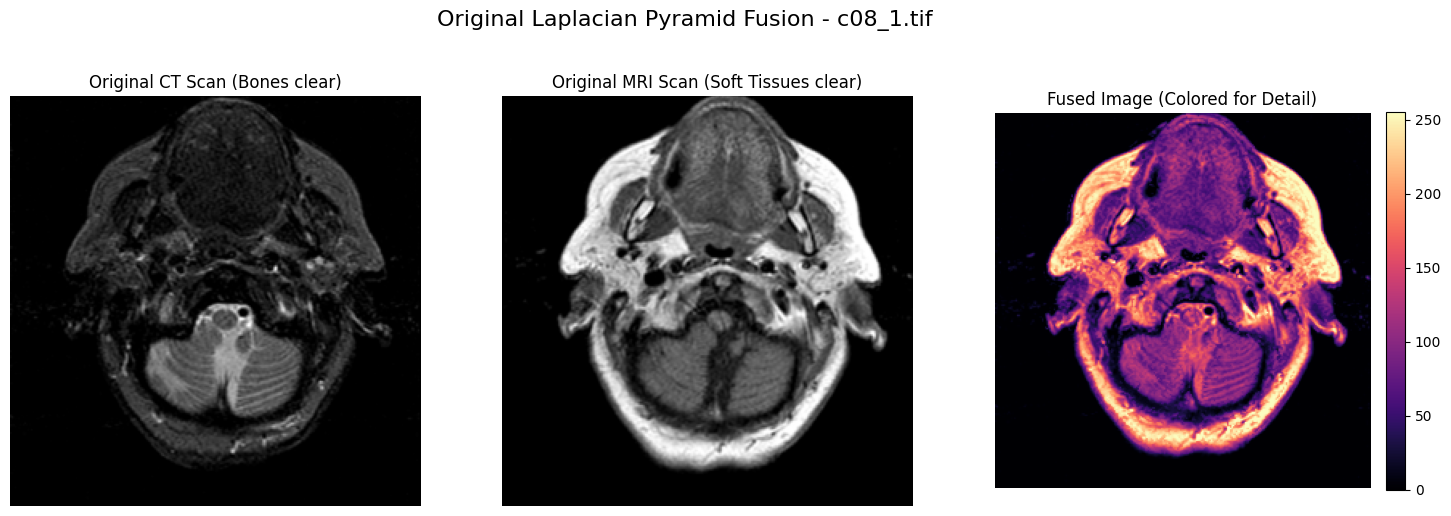

Performing Enhanced Laplacian Pyramid Fusion (emphasizing differences)...


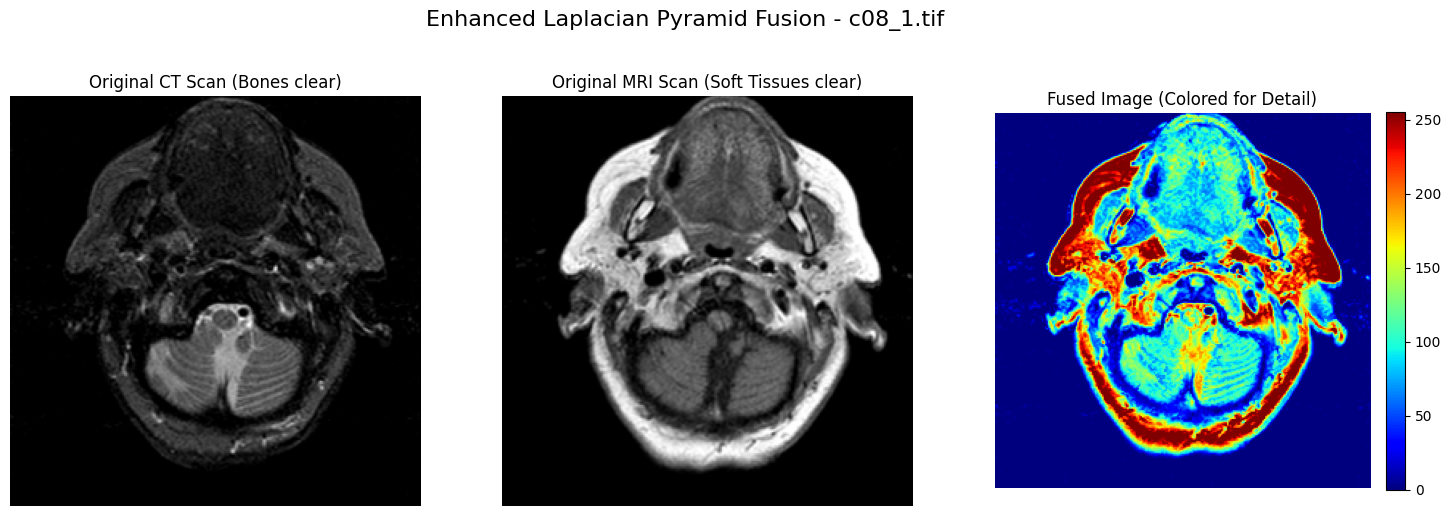

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os 

# --- 1. Load the Images ---
def load_images(ct_path, mri_path):
    """
    Loads CT and MRI images.
    Args:
        ct_path (str): Path to the CT image.
        mri_path (str): Path to the MRI image.
    Returns:
        tuple: (CT image (grayscale), MRI image (grayscale))
    """
    ct_image = cv2.imread(ct_path, cv2.IMREAD_GRAYSCALE)
    mri_image = cv2.imread(mri_path, cv2.IMREAD_GRAYSCALE)

    if ct_image is None:
        raise FileNotFoundError(f"CT image not found at {ct_path}")
    if mri_image is None:
        raise FileNotFoundError(f"MRI image not found at {mri_path}")

    return ct_image, mri_image



# --- 2. Image Fusion Techniques ---



def laplacian_pyramid_fusion(ct_image, mri_image, levels=4):
    """
    Performs image fusion using Laplacian Pyramids.
    This method often yields better results by preserving details.
    """
    # Build Gaussian Pyramids for both images
    G_ct = [ct_image.astype(np.float32)]
    G_mri = [mri_image.astype(np.float32)]
    for i in range(levels):
        G_ct.append(cv2.pyrDown(G_ct[-1]))
        G_mri.append(cv2.pyrDown(G_mri[-1]))

    # Build Laplacian Pyramids
    L_ct = [G_ct[levels - 1]]
    L_mri = [G_mri[levels - 1]]
    for i in range(levels - 1, 0, -1):
        # Ensure sizes match for subtraction before pyrUp
        size_ct = (G_ct[i-1].shape[1], G_ct[i-1].shape[0])
        size_mri = (G_mri[i-1].shape[1], G_mri[i-1].shape[0])

        L_ct.append(cv2.subtract(G_ct[i - 1], cv2.resize(cv2.pyrUp(G_ct[i]), size_ct)))
        L_mri.append(cv2.subtract(G_mri[i - 1], cv2.resize(cv2.pyrUp(G_mri[i]), size_mri)))

    # Fuse Laplacian pyramids by taking the maximum absolute value at each pixel
    LS = []
    for la, lb in zip(L_ct, L_mri):
        ls_level = np.where(np.abs(la) >= np.abs(lb), la, lb)
        LS.append(ls_level)

    # Reconstruct the fused image from the fused Laplacian pyramid
    fused = LS[0]
    for i in range(1, levels):
        fused = cv2.pyrUp(fused)
        # Ensure sizes match before adding, particularly at the highest resolution
        if fused.shape != LS[i].shape:
            fused = cv2.resize(fused, (LS[i].shape[1], LS[i].shape[0]))
        fused = cv2.add(fused, LS[i])

    return np.clip(fused, 0, 255).astype(np.uint8)


def laplacian_pyramid_fusion_enhanced_diff(ct_image, mri_image, levels=4, diff_emphasis_factor=0.5):
    """
    Performs image fusion using Laplacian Pyramids, with enhanced emphasis
    on differences between the images for detection.

    Args:
        ct_image (np.array): Grayscale CT image.
        mri_image (np.array): Grayscale MRI image.
        levels (int): Number of pyramid levels.
        diff_emphasis_factor (float): A factor to multiply the difference
                                       component. Higher values mean more
                                       emphasis on differences.
    Returns:
        np.array: Fused image.
    """
    # Build Gaussian Pyramids for both images
    G_ct = [ct_image.astype(np.float32)]
    G_mri = [mri_image.astype(np.float32)]
    for i in range(levels):
        G_ct.append(cv2.pyrDown(G_ct[-1]))
        G_mri.append(cv2.pyrDown(G_mri[-1]))

    # Build Laplacian Pyramids
    L_ct = [G_ct[levels - 1]]
    L_mri = [G_mri[levels - 1]]
    for i in range(levels - 1, 0, -1):
        # Ensure sizes match for subtraction before pyrUp
        size_ct = (G_ct[i-1].shape[1], G_ct[i-1].shape[0])
        size_mri = (G_mri[i-1].shape[1], G_mri[i-1].shape[0])

        L_ct.append(cv2.subtract(G_ct[i - 1], cv2.resize(cv2.pyrUp(G_ct[i]), size_ct)))
        L_mri.append(cv2.subtract(G_mri[i - 1], cv2.resize(cv2.pyrUp(G_mri[i]), size_mri)))

    # Fuse Laplacian pyramids with enhanced difference emphasis
    LS = []
    for la, lb in zip(L_ct, L_mri):
        alpha = 0.5 # Base weight for averaging
        fused_base = alpha * la + (1 - alpha) * lb
        difference_component = np.abs(la - lb) * diff_emphasis_factor
        ls_level = fused_base + np.sign(fused_base) * difference_component
        LS.append(ls_level)

    # Reconstruct the fused image from the fused Laplacian pyramid
    fused = LS[0]
    for i in range(1, levels):
        fused = cv2.pyrUp(fused)
        # Ensure sizes match before adding, particularly at the highest resolution
        if fused.shape != LS[i].shape:
            fused = cv2.resize(fused, (LS[i].shape[1], LS[i].shape[0]))
        fused = cv2.add(fused, LS[i])

    return np.clip(fused, 0, 255).astype(np.uint8)


# --- 4. Quality Assessment (Qualitative) ---
def display_images(original_ct, original_mri, fused_image, title="Image Fusion Results", fused_cmap='gray'):
    """
    Displays the original CT, MRI, and the fused image for qualitative assessment.
    Args:
        original_ct (np.array): Original CT image.
        original_mri (np.array): Original MRI image.
        fused_image (np.array): Fused image.
        title (str): Overall title for the plot.
        fused_cmap (str): Colormap to use for the fused image. Default is 'gray'.
    """
    plt.figure(figsize=(18, 6)) # Increased figure size for colorbar

    plt.subplot(1, 3, 1)
    plt.imshow(original_ct, cmap='gray')
    plt.title('Original CT Scan (Bones clear)')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(original_mri, cmap='gray')
    plt.title('Original MRI Scan (Soft Tissues clear)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    # Apply the specified colormap to the fused image
    im = plt.imshow(fused_image, cmap=fused_cmap)
    plt.title('Fused Image (Colored for Detail)')
    plt.axis('off')
    # Add a colorbar for the fused image to interpret colors
    plt.colorbar(im, ax=plt.gca(), fraction=0.046, pad=0.04)


    plt.suptitle(title, fontsize=16)
    plt.show()

# --- Main Program Execution ---
if __name__ == "__main__":
    image_folder = 'medical' # Your folder containing medical images

    # Get all files in the directory
    all_files = os.listdir(image_folder)

    # Filter for .tif files and sort them to ensure consistent pairing
    tif_files = sorted([f for f in all_files if f.endswith('.tif')])

    # Assuming CT and MRI images are named consistently, e.g., 'c01_1.tif' (CT) and 'c01_2.tif' (MRI)
    # This logic needs to be adapted based on your actual file naming convention
    image_pairs = []
    for i in range(0, len(tif_files), 2):
        if i + 1 < len(tif_files):
            # Basic check to see if they might be a pair based on naming convention
            # You might need a more robust check if your naming is less structured
            ct_name_parts = tif_files[i].split('_')
            mri_name_parts = tif_files[i+1].split('_')

            if len(ct_name_parts) > 1 and len(mri_name_parts) > 1 and \
               ct_name_parts[0] == mri_name_parts[0] and \
               ct_name_parts[1].startswith('1') and mri_name_parts[1].startswith('2'):
                image_pairs.append((os.path.join(image_folder, tif_files[i]),
                                    os.path.join(image_folder, tif_files[i+1])))
            else:
                print(f"Skipping potential non-pair or mismatched naming: {tif_files[i]}, {tif_files[i+1]}")
        else:
            print(f"Skipping odd file: {tif_files[i]}")

    if not image_pairs:
        print(f"No image pairs found in '{image_folder}'. Please ensure files are named consistently (e.g., 'prefix_1.tif' for CT, 'prefix_2.tif' for MRI).")
    else:
        for ct_image_path, mri_image_path in image_pairs:
            print(f"\n--- Processing image pair: CT: {ct_image_path}, MRI: {mri_image_path} ---")

            try:
                ct_original, mri_original = load_images(ct_image_path, mri_image_path)


                print("Performing Original Laplacian Pyramid Fusion...")
                fused_laplacian_original = laplacian_pyramid_fusion(ct_original, mri_original, levels=4)
                display_images(ct_original, mri_original, fused_laplacian_original, f"Original Laplacian Pyramid Fusion - {os.path.basename(ct_image_path)}", fused_cmap='magma')

                print("Performing Enhanced Laplacian Pyramid Fusion (emphasizing differences)...")
                fused_laplacian_enhanced = laplacian_pyramid_fusion_enhanced_diff(ct_original,mri_original, levels=4, diff_emphasis_factor=0.7)
                display_images(ct_original, mri_original, fused_laplacian_enhanced, f"Enhanced Laplacian Pyramid Fusion - {os.path.basename(ct_image_path)}", fused_cmap='jet')

                
            except FileNotFoundError as e:
                print(f"Error: {e}. Skipping this pair.")
            except Exception as e:
                print(f"An unexpected error occurred for {ct_image_path}, {mri_image_path}: {e}")